In [1]:
import time, matplotlib, sklearn

# visualizatoin 
import matplotlib.pyplot as plt 

# data wrangling
import pandas as pd
import numpy as np 

# data preprocessing
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import SimpleImputer

# learning
from sklearn.linear_model import LogisticRegression

# the data intro has been tested with the following versions
print("pandas        Tested version: 2.0.3   Your version: %s" % pd.__version__)
print("numpy         Tested version: 1.21.5  Your version: %s" % np.__version__)
print("matplotlib    Tested version: 3.5.3   Your version: %s" % matplotlib.__version__)
print("scikit-learn  Tested version: 1.2.2   Your version: %s" % sklearn.__version__)

pandas        Tested version: 2.0.3   Your version: 2.1.4
numpy         Tested version: 1.21.5  Your version: 1.26.4
matplotlib    Tested version: 3.5.3   Your version: 3.8.0
scikit-learn  Tested version: 1.2.2   Your version: 1.2.2


In [2]:
# additional imports

from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import graphviz


# Load data
If you put the data set in the same folder as this notebook, you can use the following code to load the data set. 

In [4]:
# description
description = pd.read_csv('data\\WiDS_Datathon_2020_Dictionary.csv')
description_dict = description.set_index('Variable Name').to_dict(orient='index')
# data
df = pd.read_csv('data\\training_v2.csv')

df.head()

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,66154,25312,118,0,68.0,22.73,0,Caucasian,M,180.3,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,114252,59342,81,0,77.0,27.42,0,Caucasian,F,160.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
2,119783,50777,118,0,25.0,31.95,0,Caucasian,F,172.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
3,79267,46918,118,0,81.0,22.64,1,Caucasian,F,165.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
4,92056,34377,33,0,19.0,NaN,0,Caucasian,M,188.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma


The dataset contains many different variables, including:

#### Target variable
* *hospital_death*: 'Whether the patient died during this hospitalization.

#### Identifiers
* *patient_id*: Unique identifier associated with a patient
* *encounter_id*: Unique identifier associated with a patient unit stay
* *hospital_id*: Unique identifier associated with a hospital
* *icu_id*: A unique identifier for the unit to which the patient was admitted

#### Demographics
* *age*: The age of the patient on unit admission.
* *bmi*: The body mass index of the person on unit admission.
* *ethnicity*: The common national or cultural tradition which the person belongs to.
* *gender*: The genotypical sex of the patient.
* *height*: The height of the person on unit admission

#### Health indicators
A few examples:
* *elective_surgery*: Whether the patient was admitted to the hospital for an elective surgical operation
* *h1_diasbp_invasive_max*: The patient's highest diastolic blood pressure during the first hour of their unit stay, invasively measured
* *h1_diasbp_invasive_min*: The patient's lowest diastolic blood pressure during the first hour of their unit stay, invasively measured
* *gcs_verbal_apache*: The verbal component of the Glasgow Coma Scale measured during the first 24 hours which results in the highest APACHE III score
* *immunosuppression*: Whether the patient has their immune system suppressed within six months prior to ICU admission for any of the following reasons; radiation therapy, chemotherapy, use of non-cytotoxic immunosuppressive drugs, high dose steroids (at least 0.3 mg/kg/day of methylprednisolone or equivalent for at least 6 months).

In [6]:
# you can retrieve the description of a variable in the data set from the description dictionary as follows
"""temp_apache
urineoutput_apache
ventilated_apache
wbc_apache
apache_4a_hospital_death_prob
apache_4a_icu_death_prob
apache_3j_bodysystem
apache_2_bodysystem"""

description_dict['icu_admit_source']

{'Category': 'demographic',
 'Unit of Measure': nan,
 'Data Type': 'string',
 'Description': 'The location of the patient prior to being admitted to the unit',
 'Example': 'Operating room'}

# Data analysis (kasra)

In [8]:
# length of the data
f"data is consist of {len(df)} rows and {len(df.columns)} columns"

'data is consist of 91713 rows and 186 columns'

In [9]:
# checking what % of cells are missing in whole data
missing_values = df.isnull().sum().sum()
total_cells = np.product(df.shape)
missing_percent = (missing_values/total_cells) * 100
f"{missing_values} missing values (cells) in the data, which is {missing_percent:.2f}% of the data"

'5743492 missing values (cells) in the data, which is 33.67% of the data'

In [10]:
# calculate missing count and missing percentage for each column
missing_count = df.isna().sum()
missing_percentage = df.isna().mean() * 100

missing_info = pd.DataFrame({
    'missing_percentage': missing_percentage,
    'missing_count': missing_count,
    
})

missing_info = missing_info.sort_values(by='missing_percentage', ascending=False)
missing_info.head(50)

,missing_percentage,missing_count
h1_bilirubin_min,92.265001,84619
h1_bilirubin_max,92.265001,84619
h1_lactate_max,91.992411,84369
h1_lactate_min,91.992411,84369
h1_albumin_max,91.398166,83824
h1_albumin_min,91.398166,83824
h1_pao2fio2ratio_min,87.441257,80195
h1_pao2fio2ratio_max,87.441257,80195
h1_arterial_ph_max,83.329517,76424
h1_arterial_ph_min,83.329517,76424


In [11]:
# check the data types of the columns
numeric_df = df.select_dtypes(include=[np.number])
f"nr of numeric columns: {numeric_df.shape[1]}"

'nr of numeric columns: 178'

In [12]:
non_numeric_df = df.select_dtypes(exclude=[np.number])
print(f"nr of non-numeric columns: {non_numeric_df.shape[1]}")
print(non_numeric_df.columns)

nr of non-numeric columns: 8
Index(['ethnicity', 'gender', 'hospital_admit_source', 'icu_admit_source',
       'icu_stay_type', 'icu_type', 'apache_3j_bodysystem',
       'apache_2_bodysystem'],
      dtype='object')


In [13]:
# seeing what % of deaths were male and what % of deaths female
death_counts = df[df['hospital_death'] == 1]['gender'].value_counts(normalize=True) * 100
print(f"death counts per gender: {death_counts}")

# comparing the death rate for different genders
death_counts_female = len(df[(df['gender'] == 'F') & (df['hospital_death'] == 1)])/len(df[df['gender'] == 'F']) * 100
death_count_male = len(df[(df['gender'] == 'M') & (df['hospital_death'] == 1)])/len(df[df['gender'] == 'M']) * 100
print(f"The percentages of deaths of females and males out of the total number of females and males\nrespectively, {death_counts_female}% compared to {death_count_male}%")

death counts per gender: gender
M    52.813962
F    47.186038
Name: proportion, dtype: float64
The percentages of deaths of females and males out of the total number of females and males
respectively, 8.83725336933608% compared to 8.44165032646708%


Ethnicities in the data are: ['Caucasian' nan 'Hispanic' 'African American' 'Asian' 'Native American'
 'Other/Unknown']


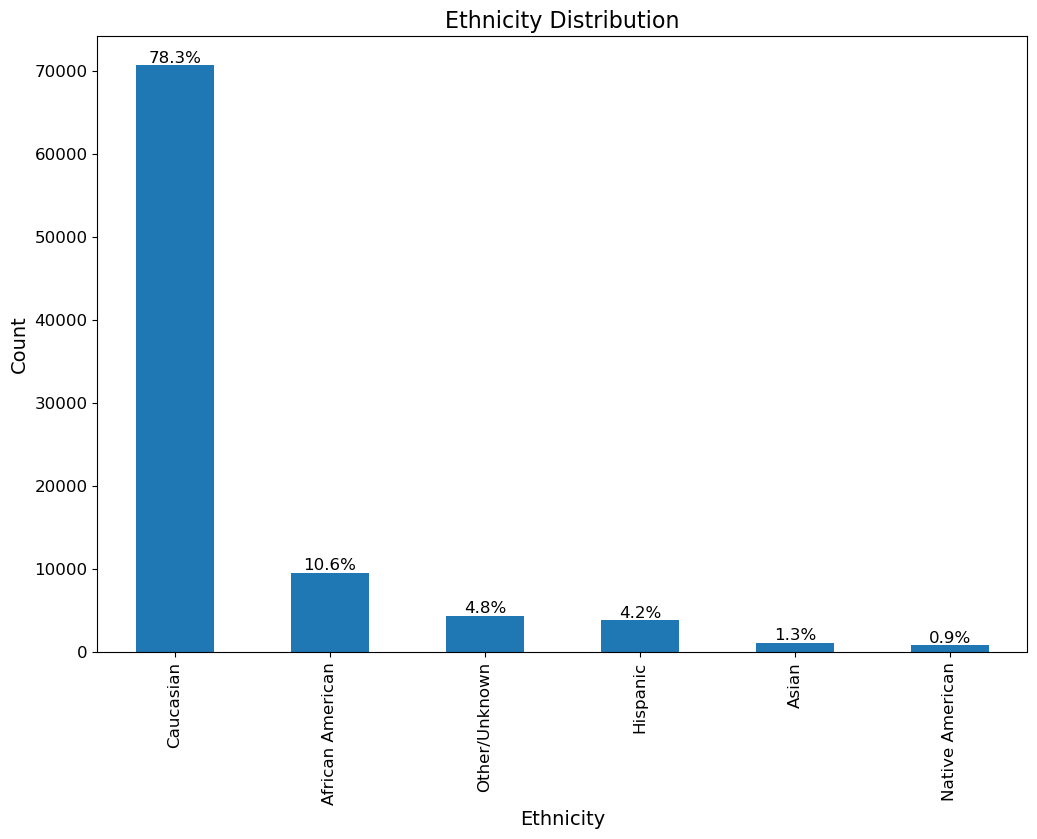

In [14]:
print(f"Ethnicities in the data are: {df['ethnicity'].unique()}")

# plotting eth
eth_counts = df['ethnicity'].value_counts()
eth_percent = eth_counts / eth_counts.sum() * 100

plt.figure(figsize=(12, 8))
ax = eth_counts.plot(kind='bar', fontsize=12)

plt.title("Ethnicity Distribution", fontsize=16)
plt.xlabel("Ethnicity", fontsize=14)
plt.ylabel("Count", fontsize=14)

for i, count in enumerate(eth_counts):
    plt.text(i, count, f'{eth_percent.iloc[i]:.1f}%', ha='center', va='bottom', fontsize=12)

plt.show()

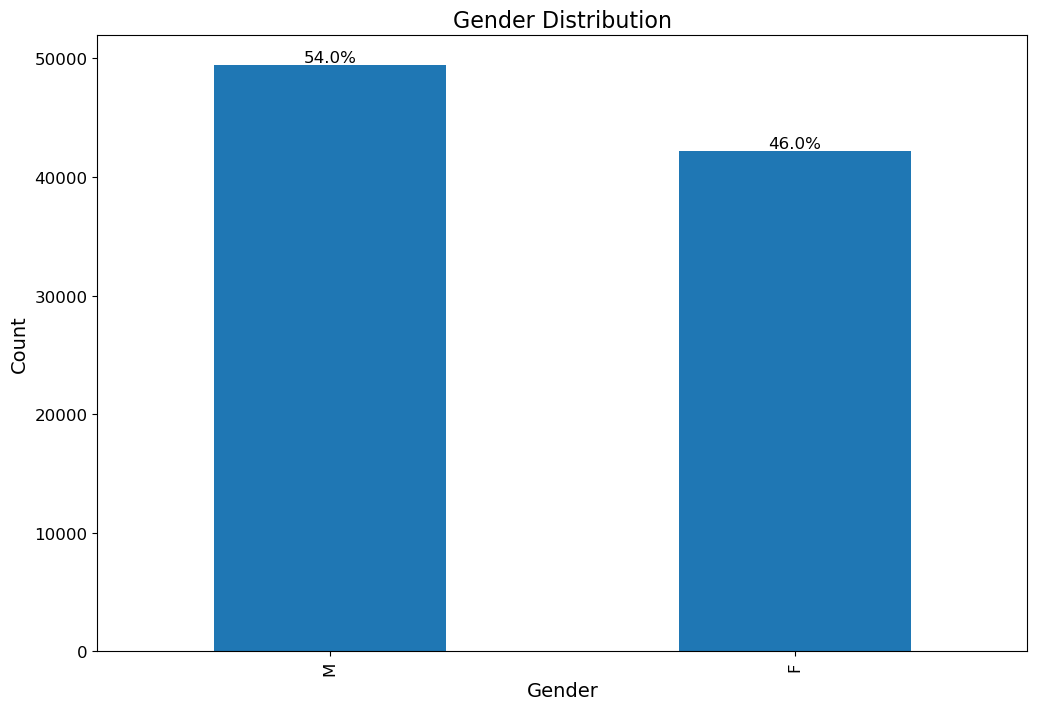

In [15]:
# plotting gender distribution

gen_counts = df['gender'].value_counts()
gen_percent = gen_counts / gen_counts.sum() * 100

plt.figure(figsize=(12, 8))
ax = gen_counts.plot(kind='bar', fontsize=12)

plt.title("Gender Distribution", fontsize=16)
plt.xlabel("Gender", fontsize=14)
plt.ylabel("Count", fontsize=14)

for i, count in enumerate(gen_counts):
    plt.text(i, count, f'{gen_percent.iloc[i]:.1f}%', ha='center', va='bottom', fontsize=12)

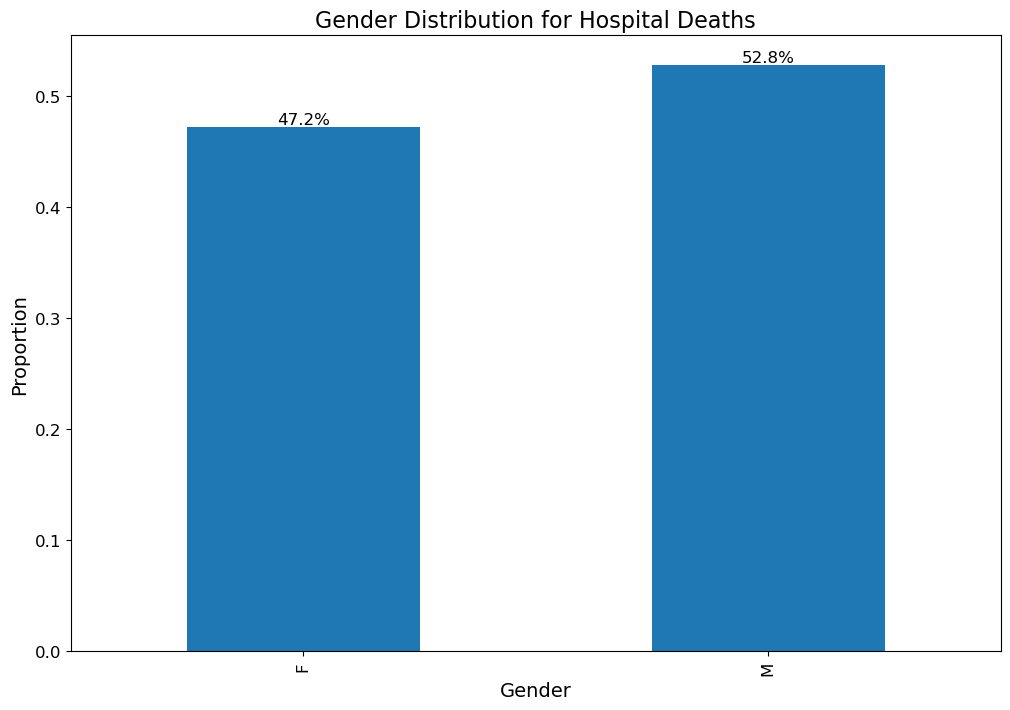

In [16]:
gen_death = df.groupby('hospital_death')['gender'].value_counts(normalize=True).unstack()
gen_death_1 = gen_death.loc[1]

plt.figure(figsize=(12, 8))
ax = gen_death_1.plot(kind='bar', fontsize=12)

plt.title("Gender Distribution for Hospital Deaths", fontsize=16)
plt.xlabel("Gender", fontsize=14)
plt.ylabel("Proportion", fontsize=14)

for i, proportion in enumerate(gen_death_1):
    plt.text(i, proportion, f'{proportion:.1%}', ha='center', va='bottom', fontsize=12)

plt.show()

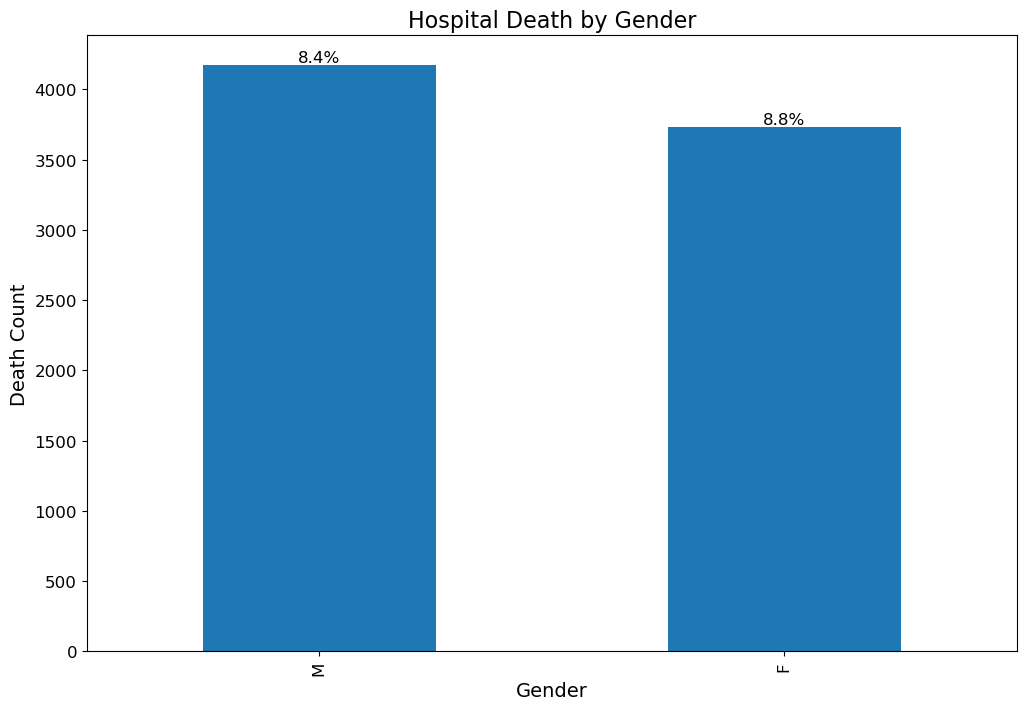

In [17]:
# compute death counts per gender
dead_counts = df[df['hospital_death'] == 1]['gender'].value_counts()
total_counts = df['gender'].value_counts()
death_percent = dead_counts / total_counts * 100

plt.figure(figsize=(12, 8))
ax = dead_counts.plot(kind='bar', fontsize=12)

plt.title("Hospital Death by Gender", fontsize=16)
plt.xlabel("Gender", fontsize=14)
plt.ylabel("Death Count", fontsize=14)

for i, count in enumerate(dead_counts):
    plt.text(i, count, f'{death_percent.iloc[i]:.1f}%', ha='center', va='bottom', fontsize=12)

plt.show()

In [18]:
# Select only numeric columns from df
numeric_df = df.select_dtypes(include=[np.number])

# Compute correlations with the target variable 'hospital_death'
correlations = numeric_df.corr()['hospital_death'].drop('hospital_death').abs().sort_values(ascending=False)

ranking_df = pd.DataFrame({
    'feature': correlations.index,
    'importance': correlations.values
})

print("Absolute Pearson Correlation of each feature with hospital_death:")
ranking_df.index = np.arange(1, len(ranking_df) + 1)
ranking_df.head(30)

Absolute Pearson Correlation of each feature with hospital_death:


,feature,importance
1,d1_lactate_min,0.403614
2,d1_lactate_max,0.399029
3,h1_lactate_min,0.344046
4,h1_lactate_max,0.340951
5,apache_4a_hospital_death_prob,0.311043
6,apache_4a_icu_death_prob,0.283913
7,gcs_motor_apache,0.282449
8,gcs_eyes_apache,0.260373
9,gcs_verbal_apache,0.241044
10,d1_sysbp_invasive_min,0.234382


<Figure size 2500x6000 with 0 Axes>

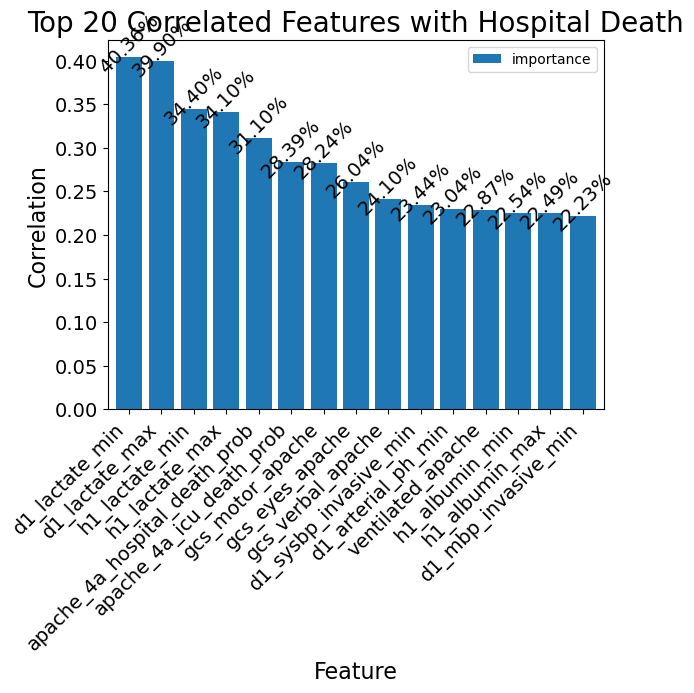

In [19]:
# plot the top 20 correlated features with hospital_death
plt.figure(figsize=(25, 60))
ax = ranking_df.head(15).set_index('feature').plot(kind='bar', fontsize=14, width=0.8)

plt.title("Top 20 Correlated Features with Hospital Death", fontsize=20)
plt.xlabel("Feature", fontsize=16)
plt.ylabel("Correlation", fontsize=16)

# Add percentages on top of each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2%}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=14, rotation=45)

# Tilt the labels for bars
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=14)

plt.show()

In [20]:
for i in df.columns:
    if 'apache' in i:
        print(i)

albumin_apache
apache_2_diagnosis
apache_3j_diagnosis
apache_post_operative
arf_apache
bilirubin_apache
bun_apache
creatinine_apache
fio2_apache
gcs_eyes_apache
gcs_motor_apache
gcs_unable_apache
gcs_verbal_apache
glucose_apache
heart_rate_apache
hematocrit_apache
intubated_apache
map_apache
paco2_apache
paco2_for_ph_apache
pao2_apache
ph_apache
resprate_apache
sodium_apache
temp_apache
urineoutput_apache
ventilated_apache
wbc_apache
apache_4a_hospital_death_prob
apache_4a_icu_death_prob
apache_3j_bodysystem
apache_2_bodysystem


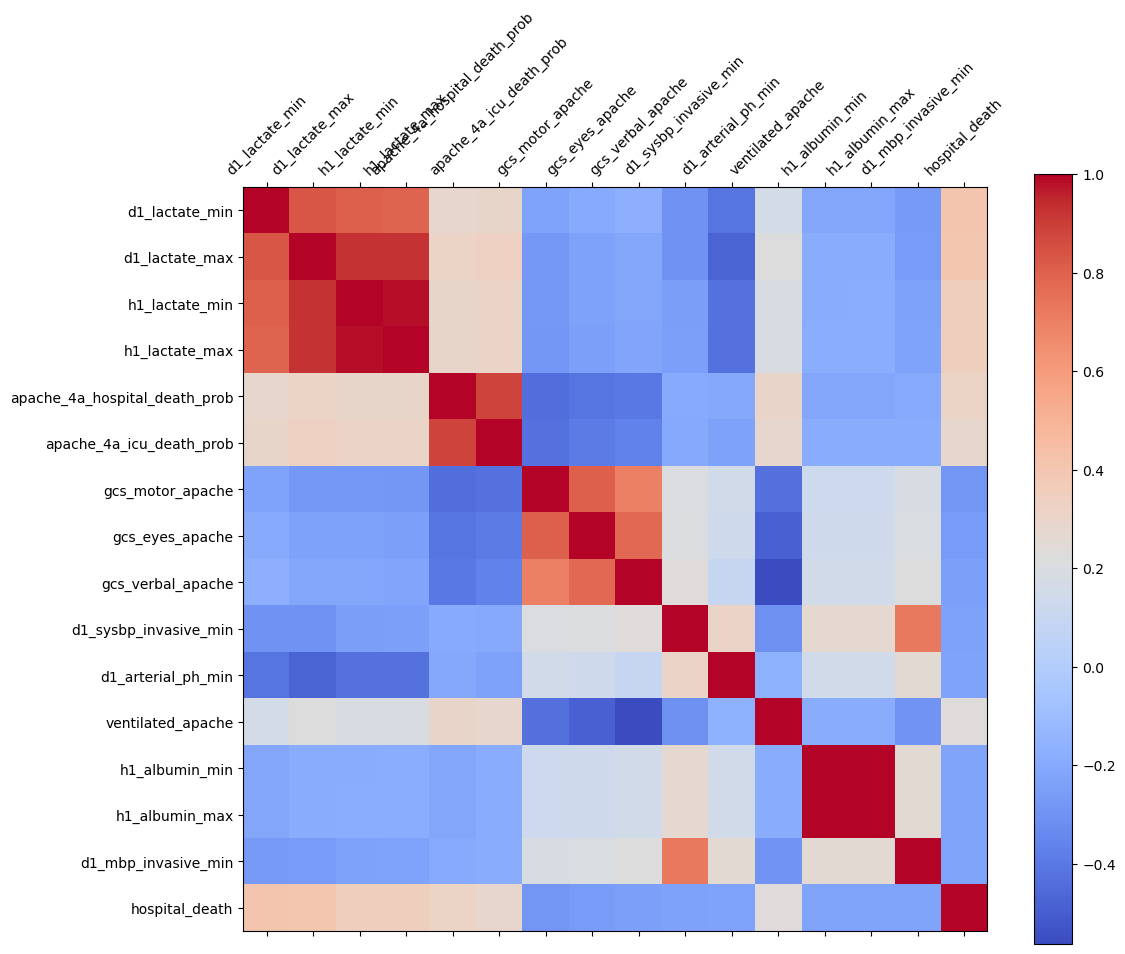

In [21]:
# correlation matrix for the top 15 correlated features with hospital_death
top_features = ranking_df.head(15)['feature'].values
top_features = np.append(top_features, 'hospital_death')

top_corr = df[top_features].corr()

plt.figure(figsize=(12, 10))
ax = plt.gca()

cax = ax.matshow(top_corr, cmap='coolwarm')
plt.colorbar(cax)

plt.xticks(range(len(top_corr.columns)), top_corr.columns, rotation=45)
plt.yticks(range(len(top_corr.columns)), top_corr.columns)

plt.show()

In [22]:
# we could possibly have categories for some columns to see how each category in that column is related to the target variable
# e.g. dividing weight into underweight, normal, overweight, obese and see how it relates to hospital_death 
# (however leaving it as numerical) still gives us the correlation with the target variable but it might be
#  nicer for the report and explanation

In [23]:
# drop columns with missing value higher than threshold )
nr_columns = len(df.columns)
threshold = 0.8
X = df.copy().dropna(thresh=threshold*len(df), axis=1)

print(f"dropped {nr_columns - len(X.columns)} columns with missing values higher than {threshold*100}%")
print(f"we could play with threshold but it doesnt have much effect since lot of columns barely have any values in them (explain kasra)")

missing_values_after_dropping = X.isnull().sum().sum()
total_cells = np.product(X.shape)
missing_percent = (missing_values_after_dropping/total_cells) * 100
f"{missing_values} missing values (cells) in the data, which is {missing_percent:.2f}% of the data"

dropped 82 columns with missing values higher than 80.0%
we could play with threshold but it doesnt have much effect since lot of columns barely have any values in them (explain kasra)


'5743492 missing values (cells) in the data, which is 4.47% of the data'

In [24]:
numeric_columns = X.select_dtypes(include=[np.number]).columns
categorical_columns = X.select_dtypes(exclude=[np.number]).columns

print(f"numeric columns: {len(numeric_columns)}")
print(f"categorical columns: {len(categorical_columns)}")

numeric columns: 97
categorical columns: 7


In [25]:
# checking if there are any columns with only one unique value and printing those columns
unique_values = X.nunique()
unique_values = unique_values[unique_values == 1]

print(f"there are {len(unique_values)} columns with only one unique value")
print(unique_values)

there are 1 columns with only one unique value
readmission_status    1
dtype: int64


In [26]:
# Finding columns with low variance in numerical columns
variance_threshold = 0.01
low_variance = X[numeric_columns].var() < variance_threshold

print(f"there are {low_variance.sum()} columns with low variance in numerical columns")
print(X[numeric_columns].columns[low_variance])
print(X[numeric_columns].var()[low_variance])

there are 5 columns with low variance in numerical columns
Index(['readmission_status', 'gcs_unable_apache', 'aids', 'leukemia',
       'lymphoma'],
      dtype='object')
readmission_status    0.000000
gcs_unable_apache     0.009438
aids                  0.000856
leukemia              0.007016
lymphoma              0.004115
dtype: float64


In [27]:
# Finding the binary columns according to its description 
binary_columns = []
for col in X.columns:
    if description_dict[col]['Data Type'] == 'binary':
        binary_columns.append(col)

# excluding the target variable
binary_columns.remove('hospital_death')

print(f"there are {len(binary_columns)} binary columns")
print(binary_columns)

there are 15 binary columns
['elective_surgery', 'readmission_status', 'apache_post_operative', 'arf_apache', 'gcs_unable_apache', 'intubated_apache', 'ventilated_apache', 'aids', 'cirrhosis', 'diabetes_mellitus', 'hepatic_failure', 'immunosuppression', 'leukemia', 'lymphoma', 'solid_tumor_with_metastasis']


In [28]:
# filling in missing values for numerical columns with mean of the column, excluding binary columns
numeric_columns_excluding_binary = numeric_columns.difference(binary_columns)
X[numeric_columns_excluding_binary] = X[numeric_columns_excluding_binary].fillna(X[numeric_columns_excluding_binary].mean())

# filling in missing values for categorical columns with the most frequent value in the column
X[categorical_columns] = X[categorical_columns].apply(lambda x: x.fillna(x.value_counts().idxmax()))

# check if there are any missing values left
missing_values = X.isnull().sum().sum()
f"there are {missing_values} missing values left in the data"


'there are 8902 missing values left in the data'

In [29]:
# Dropping final rows that have missing values (due to not interpolating binary values)
X = X.dropna()

# check if there are any missing values left
missing_values = X.isnull().sum().sum()
f"there are {missing_values} missing values left in the data"

'there are 0 missing values left in the data'

0 elective_surgery
1 readmission_status
2 apache_post_operative
3 arf_apache
4 gcs_unable_apache
5 intubated_apache
6 ventilated_apache
7 aids
8 cirrhosis
9 diabetes_mellitus
10 hepatic_failure
11 immunosuppression
12 leukemia
13 lymphoma
14 solid_tumor_with_metastasis


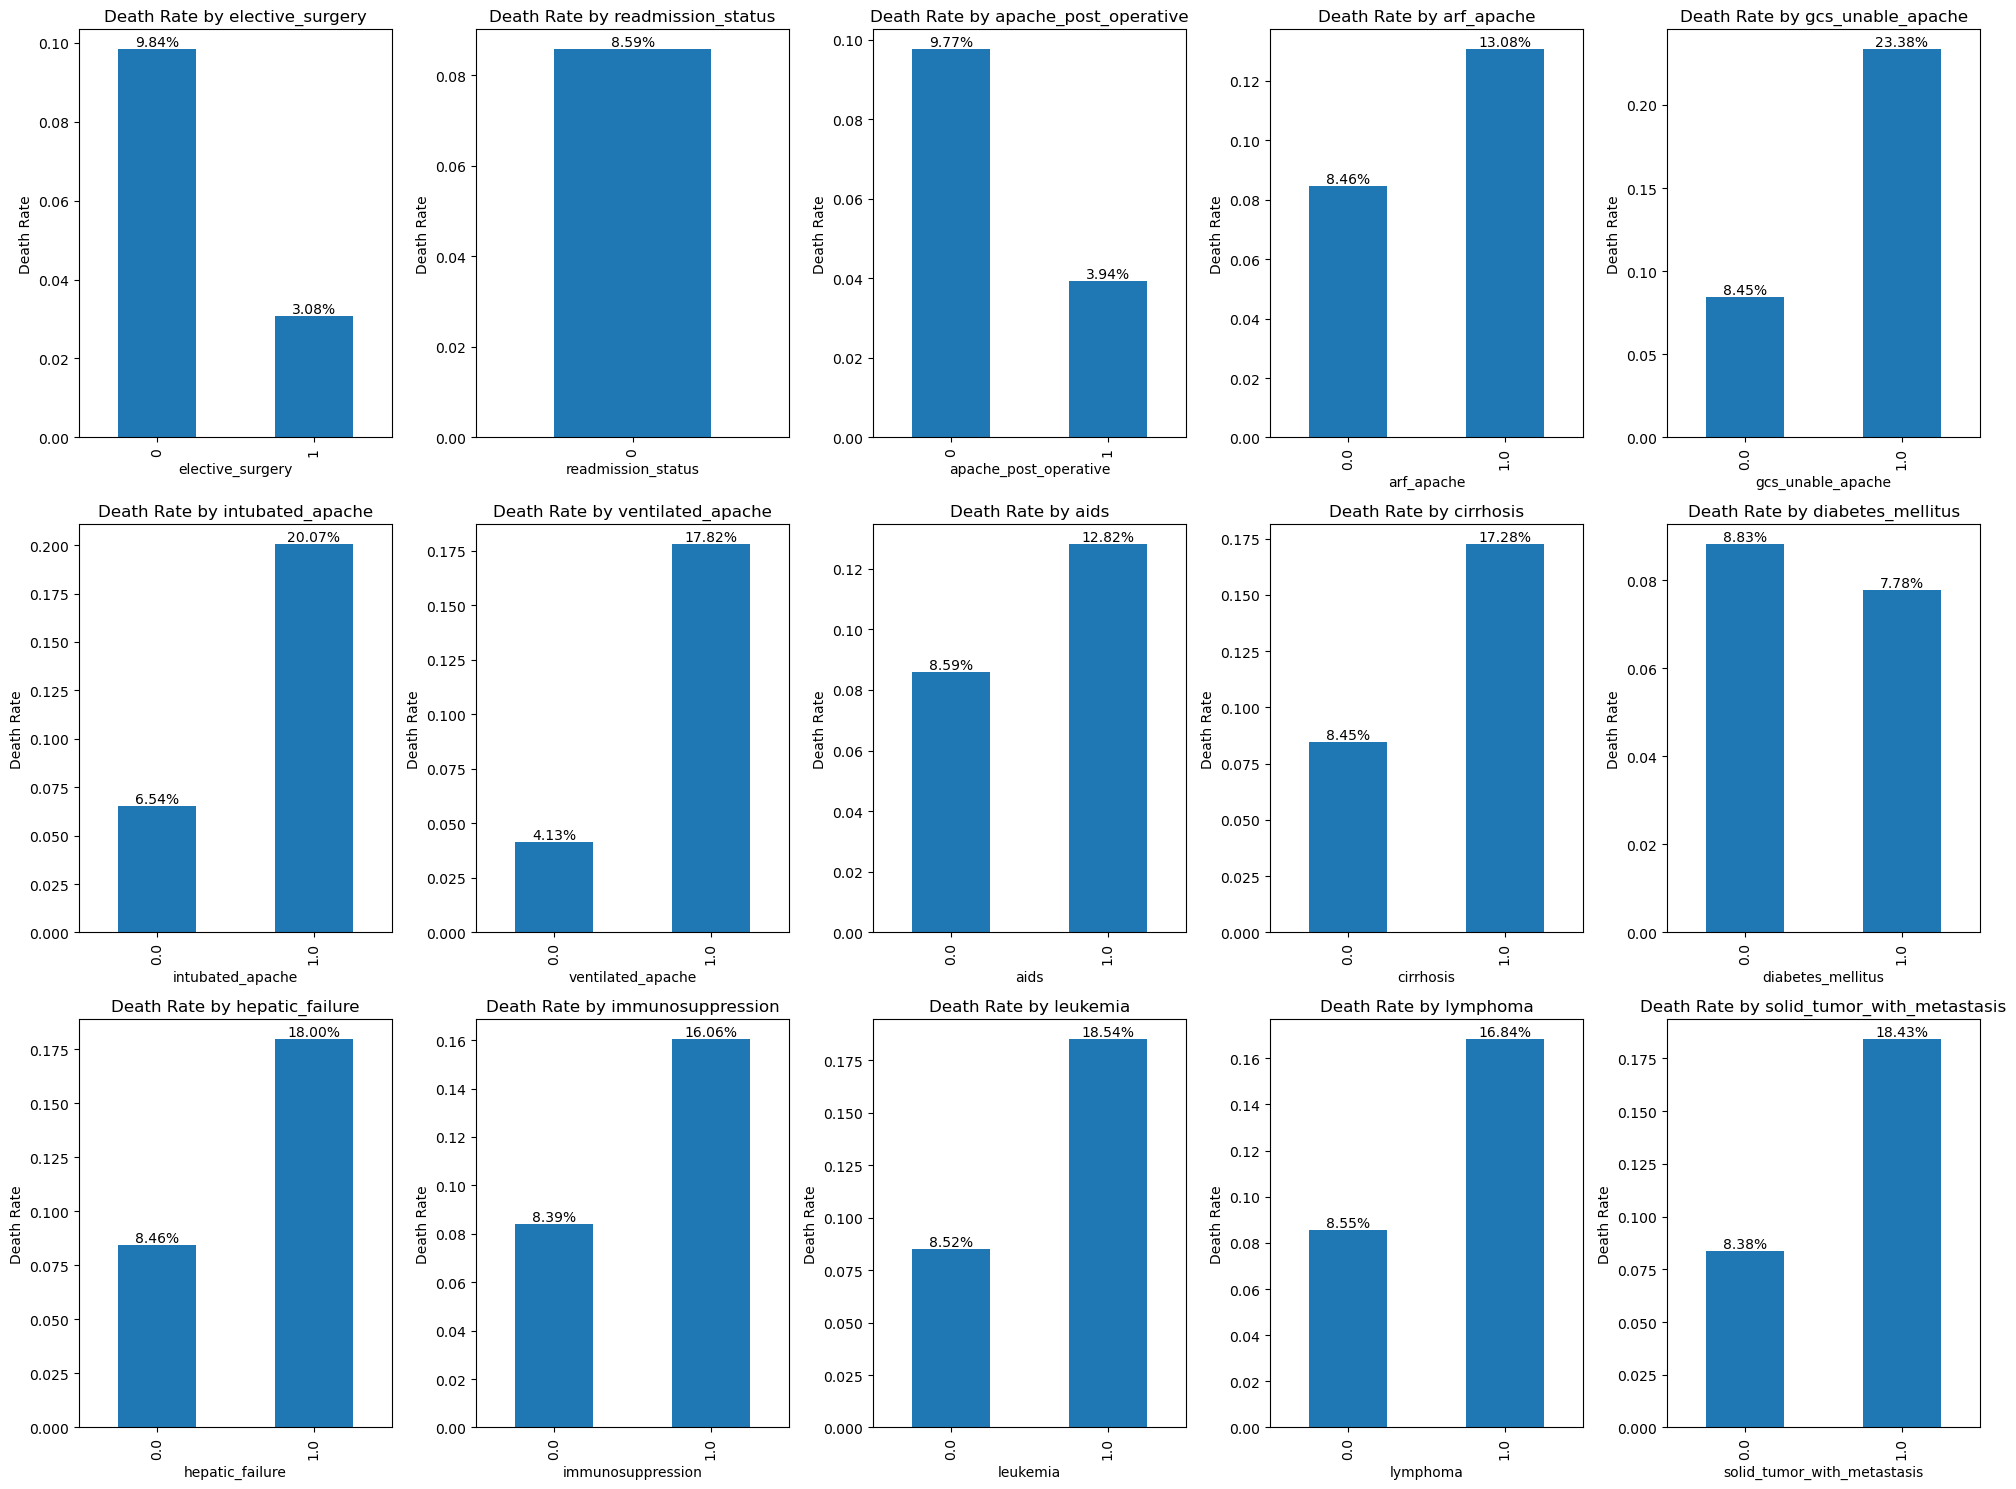

In [30]:
# plotting death rate for binary columns in sub plots of 3 * 5
fig, axes = plt.subplots(3, 5, figsize=(20, 15))
axes = axes.flatten()

for i, col in enumerate(binary_columns):
    print(i, col)
    death_rate = X.groupby(col)['hospital_death'].mean()
    death_rate.plot(kind='bar', ax=axes[i])
    axes[i].set_title(f"Death Rate by {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Death Rate")
    
    for j, rate in enumerate(death_rate):
        axes[i].text(j, rate, f'{rate:.2%}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

In [31]:
# Final row count after preprocessing
f"final row count after preprocessing: {len(X)}"

'final row count after preprocessing: 90676'

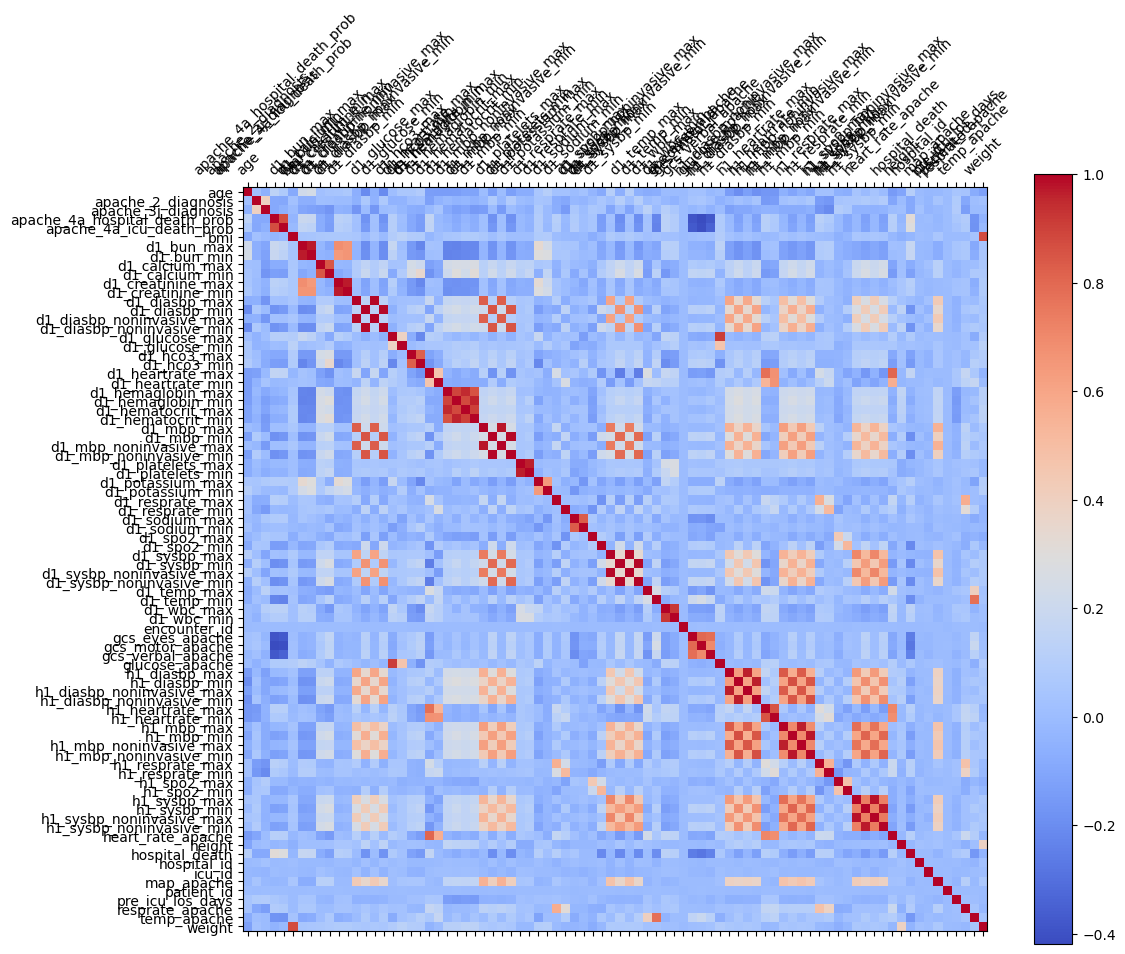

In [32]:
# plotting correlation matrix for numerical columns
plt.figure(figsize=(12, 10))
ax = plt.gca()

cax = ax.matshow(X[numeric_columns_excluding_binary].corr(), cmap='coolwarm')
plt.colorbar(cax)

plt.xticks(range(len(X[numeric_columns_excluding_binary].columns)), X[numeric_columns_excluding_binary].columns, rotation=45)
plt.yticks(range(len(X[numeric_columns_excluding_binary].columns)), X[numeric_columns_excluding_binary].columns)

plt.show()

In [33]:
# printing the columns with higher correlation than threshold
cor_threshold = 0.5
correlation_matrix = X[numeric_columns_excluding_binary].corr().abs()
correlation_matrix = correlation_matrix[correlation_matrix > cor_threshold]
correlation_matrix = correlation_matrix[correlation_matrix < 1]

correlated_columns = correlation_matrix.unstack().sort_values(ascending=False).drop_duplicates()
correlated_columns = correlated_columns[correlated_columns > cor_threshold]

print(f"there are {len(correlated_columns)} pairs of columns with correlation higher than {cor_threshold}")
for i, cor in correlated_columns.items():
    print(i, cor)

there are 185 pairs of columns with correlation higher than 0.5
('d1_diasbp_noninvasive_min', 'd1_diasbp_min') 0.9930204251622596
('d1_sysbp_noninvasive_max', 'd1_sysbp_max') 0.9924790115035333
('d1_sysbp_min', 'd1_sysbp_noninvasive_min') 0.9924126780676237
('d1_diasbp_noninvasive_max', 'd1_diasbp_max') 0.992339121145702
('d1_mbp_min', 'd1_mbp_noninvasive_min') 0.9904532378141179
('h1_sysbp_max', 'h1_sysbp_noninvasive_max') 0.9798008422782374
('h1_mbp_noninvasive_min', 'h1_mbp_min') 0.9764411687631392
('d1_mbp_noninvasive_max', 'd1_mbp_max') 0.975320121936748
('h1_sysbp_min', 'h1_sysbp_noninvasive_min') 0.9712336398066956
('d1_creatinine_max', 'd1_creatinine_min') 0.970035753483593
('d1_bun_min', 'd1_bun_max') 0.9674172844488381
('h1_diasbp_max', 'h1_diasbp_noninvasive_max') 0.9661751670003396
('h1_mbp_noninvasive_max', 'h1_mbp_max') 0.9642448106673813
('d1_platelets_min', 'd1_platelets_max') 0.9634800201452176
('h1_diasbp_noninvasive_min', 'h1_diasbp_min') 0.9628868659555564
('d1_hema

In [34]:
dropping = ["hospital_death", "encounter_id", "patient_id", "hospital_id", "height", "icu_id", "icu_stay_type", "readmission_status", "weight", "apache_2_diagnosis", "apache_3j_diagnosis", "apache_post_operative", "arf_apache", "map_apache",
             "resprate_apache", "temp_apache", "d1_diasbp_max", "d1_diasbp_min", "d1_diasbp_noninvasive_max", "d1_diasbp_noninvasive_min", "d1_mbp_noninvasive_max", "d1_resprate_min", "d1_spo2_max", "d1_sysbp_max", "d1_sysbp_noninvasive_max", 
             "d1_temp_max", "h1_diasbp_max", "h1_diasbp_noninvasive_max", "h1_heartrate_min", "h1_mbp_max", "h1_mbp_noninvasive_max", "h1_spo2_max", "h1_sysbp_max", "h1_sysbp_noninvasive_max", "d1_calcium_max", "d1_glucose_max", "d1_glucose_min", 
             "d1_hemaglobin_max", "d1_hemaglobin_min", "d1_hematocrit_max", "d1_hematocrit_min", "d1_platelets_max", "d1_platelets_min", "d1_potassium_min", "d1_sodium_max", "d1_sodium_min", "apache_4a_hospital_death_prob", "apache_4a_icu_death_prob", 
             "apache_3j_bodysystem", "apache_2_bodysystem", "icu_type", "bmi", "ethnicity", "height", ]


keeping = ["age", "elective_surgery", "gender", "pre_icu_los_days", "gcs_eyes_apache", "gcs_motor_apache", "gcs_unable_apache", "gcs_verbal_apache", "heart_rate_apache", "intubated_apache", "ventilated_apache",
            "d1_heartrate_max", "d1_heartrate_min", "d1_mbp_max", "d1_mbp_min", "d1_mbp_noninvasive_min", "d1_resprate_max", "d1_spo2_min", "d1_sysbp_min", "d1_sysbp_noninvasive_min", "d1_temp_min", "h1_diasbp_min", "h1_diasbp_noninvasive_min", "h1_heartrate_max",
              "h1_mbp_min", "h1_mbp_noninvasive_min", "h1_resprate_max", "h1_resprate_min", "h1_spo2_min", "h1_sysbp_min", "h1_sysbp_noninvasive_min", "d1_bun_max", "d1_bun_min", "d1_calcium_min", "d1_creatinine_max", "d1_creatinine_min", "d1_hco3_max", "d1_hco3_min",
                "d1_potassium_max", "d1_wbc_max", "d1_wbc_min", "aids", "cirrhosis", "diabetes_mellitus", "hepatic_failure", "immunosuppression", "leukemia", "lymphoma", "solid_tumor_with_metastasis", "icu_admit_source"]



In [35]:
len(keeping) + len(dropping)

104

In [36]:
# going through columns one by one reading their descriptoin and deciding if they should be in final training or not

i = 1
for col in X.columns:
    print(f"{i}. col: {col}", f"Data Type: {description_dict[col]['Data Type']}", f"Description: {description_dict[col]['Description']}", sep='\n')
    if col in numeric_columns:
        print(f"Variance: {X[col].var()}")
        # we check correlation with target variable for numerical columns
        print(f"Correlation with target variable: {X[col].corr(X['hospital_death'])}")
        print(f"nr of unique values: {X[col].nunique()}")
    i += 1    
    print()

1. col: encounter_id
Data Type: integer
Description: Unique identifier associated with a patient unit stay
Variance: 1429162658.9952264
Correlation with target variable: -0.005697923012069046
nr of unique values: 90676

2. col: patient_id
Data Type: integer
Description: Unique identifier associated with a patient
Variance: 1429685130.718005
Correlation with target variable: 0.004682566523592406
nr of unique values: 90676

3. col: hospital_id
Data Type: integer
Description: Unique identifier associated with a hospital
Variance: 3951.52902932182
Correlation with target variable: -0.0013311631433794368
nr of unique values: 147

4. col: hospital_death
Data Type: binary
Description: Whether the patient died during this hospitalization
Variance: 0.0785122973584925
Correlation with target variable: 1.0
nr of unique values: 2

5. col: age
Data Type: numeric
Description: The age of the patient on unit admission
Variance: 270.5610225326034
Correlation with target variable: 0.1066987104768036
nr 

D:\Users\david_p3b8pan\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
D:\Users\david_p3b8pan\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Correlation with target variable: -0.1936100631687962
nr of unique values: 92

41. col: d1_mbp_noninvasive_max
Data Type: numeric
Description: The patient's highest mean blood pressure during the first 24 hours of their unit stay, non-invasively measured
Variance: 421.85367961661586
Correlation with target variable: -0.015696125367390606
nr of unique values: 123

42. col: d1_mbp_noninvasive_min
Data Type: numeric
Description: The patient's lowest mean blood pressure during the first 24 hours of their unit stay, non-invasively measured
Variance: 242.57179457543054
Correlation with target variable: -0.19262129897834182
nr of unique values: 92

43. col: d1_resprate_max
Data Type: numeric
Description: The patient's highest respiratory rate during the first 24 hours of their unit stay
Variance: 114.13715523799945
Correlation with target variable: 0.10271089867723736
nr of unique values: 80

44. col: d1_resprate_min
Data Type: numeric
Description: The patient's lowest respiratory rate during

In [37]:
y = X['hospital_death'].copy()
y_apache = X['apache_4a_hospital_death_prob'].copy()
X = X[keeping]
X.head()

,age,elective_surgery,gender,pre_icu_los_days,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,heart_rate_apache,intubated_apache,...,d1_wbc_min,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,icu_admit_source
0,68.0,0,M,0.541667,3.0,6.0,0.0,4.0,118.0,0.0,...,14.100000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Floor
1,77.0,0,F,0.927778,1.0,3.0,0.0,1.0,120.0,0.0,...,12.700000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Floor
2,25.0,0,F,0.000694,3.0,6.0,0.0,5.0,102.0,0.0,...,11.313536,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Accident & Emergency
3,81.0,1,F,0.000694,4.0,6.0,0.0,5.0,114.0,1.0,...,8.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Operating Room / Recovery
5,67.0,0,M,0.000694,4.0,6.0,0.0,5.0,113.0,0.0,...,10.900000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Accident & Emergency


In [38]:
# one hot encoding for icu_admit_source
X = pd.get_dummies(X, columns=['icu_admit_source'], drop_first=True)

# turning F and M into 0 and 1
X['gender'] = X['gender'].map({'F': 0, 'M': 1})

X.head()

,age,elective_surgery,gender,pre_icu_los_days,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,heart_rate_apache,intubated_apache,...,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,icu_admit_source_Floor,icu_admit_source_Operating Room / Recovery,icu_admit_source_Other Hospital,icu_admit_source_Other ICU
0,68.0,0,1,0.541667,3.0,6.0,0.0,4.0,118.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,True,False,False,False
1,77.0,0,0,0.927778,1.0,3.0,0.0,1.0,120.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,True,False,False,False
2,25.0,0,0,0.000694,3.0,6.0,0.0,5.0,102.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False
3,81.0,1,0,0.000694,4.0,6.0,0.0,5.0,114.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,False,True,False,False
5,67.0,0,1,0.000694,4.0,6.0,0.0,5.0,113.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False


# Pre-processing
This is a real-world data set, meaning that it is **messy**. Two key difficulties are categorial features and missing values.

> **To avoid information leakage, any pre-processing steps must be based on the training data only.** For example, when we compute the mean, this must be computed based on the training data set.

### Categorical Features
Many (implementations of) machine learning algorithms cannot handle categorical features automatically. This is often dealt with through *one-hot-encoding*, where each category of a feature is transformed into a binary feature.

When a feature contains many categories, this results in a very sparse data set with many features. As such, it can be worthwile to use domain expertise to merge particular categories in order to reduce the number of one-hot-encoded features.

### Missing Values
The data set contains a lot of missing values (around 35% of the values is missing). There are several ways to deal with this, some ideas to try:

* Replace missing values with the mean (numerical features) or median (categorical features), e.g., using [`SimpleImputer`](https://scikit-learn.org/stable/modules/impute.html#univariate-feature-imputation).
* Drop features with many missing values.
* Model-based imputation strategies, such as [KNNImputer](https://scikit-learn.org/stable/modules/impute.html#nearest-neighbors-imputation).
* Domain-knowledge inspired replacement. For example, for features related to medical measurements, it is expected that the entered data is abnormal in some way. As such, replacing by the mean or median can paint a skewed picture. One way to deal with this would be to identify a normal range for different measurements, based on domain expertise. *Note: this is a very time consuming strategy which we do not necessarily recommend in the time span of this project.*

We encourage you to try several approaches and see what works best.

## Example of  Minimal Pre-Processing
Below you can find an example of pre-processing the data set for classification. We showcase both 'manual' pre-processing steps through `pandas` as well as a (small) scikit-learn `Pipeline`. Feel free to use whatever you are most comfortable with in your project.

In [41]:
# lets see the all the column names and their descriptions
for i, col in enumerate(df.columns, start=1):
    print(f"{i}. {col}: {description_dict[col]['Description']}")

1. encounter_id: Unique identifier associated with a patient unit stay
2. patient_id: Unique identifier associated with a patient
3. hospital_id: Unique identifier associated with a hospital
4. hospital_death: Whether the patient died during this hospitalization
5. age: The age of the patient on unit admission
6. bmi: The body mass index of the person on unit admission
7. elective_surgery: Whether the patient was admitted to the hospital for an elective surgical operation
8. ethnicity: The common national or cultural tradition which the person belongs to
9. gender: The genotypical sex of the patient
10. height: The height of the person on unit admission
11. hospital_admit_source: The location of the patient prior to being admitted to the hospital
12. icu_admit_source: The location of the patient prior to being admitted to the unit
13. icu_id: A unique identifier for the unit to which the patient was admitted
14. icu_stay_type: nan
15. icu_type: A classification which indicates the type

In [42]:
# calculate missing values and their percentage
missing_values = df.isnull().sum()
missing_values_percentage = df.isnull().mean() * 100

# print the result using a for loop
print("Missing Values and their Percentage")
for col, missing, percentage in zip(df.columns, missing_values, missing_values_percentage):
    # print(f"{col}:, Missing Values: {missing}, Percentage: {percentage:.2f}%")
    print(f"{col}: {percentage:.2f}%")


Missing Values and their Percentage
encounter_id: 0.00%
patient_id: 0.00%
hospital_id: 0.00%
hospital_death: 0.00%
age: 4.61%
bmi: 3.74%
elective_surgery: 0.00%
ethnicity: 1.52%
gender: 0.03%
height: 1.45%
hospital_admit_source: 23.34%
icu_admit_source: 0.12%
icu_id: 0.00%
icu_stay_type: 0.00%
icu_type: 0.00%
pre_icu_los_days: 0.00%
readmission_status: 0.00%
weight: 2.97%
albumin_apache: 59.29%
apache_2_diagnosis: 1.81%
apache_3j_diagnosis: 1.20%
apache_post_operative: 0.00%
arf_apache: 0.78%
bilirubin_apache: 63.39%
bun_apache: 21.00%
creatinine_apache: 20.56%
fio2_apache: 77.27%
gcs_eyes_apache: 2.07%
gcs_motor_apache: 2.07%
gcs_unable_apache: 1.13%
gcs_verbal_apache: 2.07%
glucose_apache: 12.03%
heart_rate_apache: 0.96%
hematocrit_apache: 21.67%
intubated_apache: 0.78%
map_apache: 1.08%
paco2_apache: 77.27%
paco2_for_ph_apache: 77.27%
pao2_apache: 77.27%
ph_apache: 77.27%
resprate_apache: 1.35%
sodium_apache: 20.28%
temp_apache: 4.48%
urineoutput_apache: 53.43%
ventilated_apache: 0.

In [43]:
# printing the columns in descending order of missing values
print("Columns in descending order of missing values")
missing_values_percentage.sort_values(ascending=False).head(50)

Columns in descending order of missing values


h1_bilirubin_min          92.265001
h1_bilirubin_max          92.265001
h1_lactate_max            91.992411
h1_lactate_min            91.992411
h1_albumin_max            91.398166
h1_albumin_min            91.398166
h1_pao2fio2ratio_min      87.441257
h1_pao2fio2ratio_max      87.441257
h1_arterial_ph_max        83.329517
h1_arterial_ph_min        83.329517
h1_hco3_max               82.969699
h1_hco3_min               82.969699
h1_arterial_pco2_min      82.822501
h1_arterial_pco2_max      82.822501
h1_wbc_max                82.815958
h1_wbc_min                82.815958
h1_arterial_po2_max       82.807236
h1_arterial_po2_min       82.807236
h1_calcium_max            82.717826
h1_calcium_min            82.717826
h1_platelets_max          82.510658
h1_platelets_min          82.510658
h1_bun_max                81.876070
h1_bun_min                81.876070
h1_creatinine_max         81.729962
h1_creatinine_min         81.729962
h1_diasbp_invasive_min    81.698342
h1_diasbp_invasive_max    81

In [44]:
# nr of columns that have missing values % higher than X
X_miss = 25
nr_cols = (missing_values_percentage > X_miss).sum()
print(f"Nr of columns that have missing values % higher than {X_miss}: {nr_cols}")

Nr of columns that have missing values % higher than 25: 74


In [45]:
# printing the columns names that have missing values % higher than X and their description

print(f"Columns that have missing values % higher than {X_miss}")
for col, percentage in missing_values_percentage.items():
    if percentage > X_miss:
        print(f"{col}: {description_dict[col]['Description']}")

Columns that have missing values % higher than 25
albumin_apache: The albumin concentration measured during the first 24 hours which results in the highest APACHE III score
bilirubin_apache: The bilirubin concentration measured during the first 24 hours which results in the highest APACHE III score
fio2_apache: The fraction of inspired oxygen from the arterial blood gas taken during the first 24 hours of unit admission which produces the highest APACHE III score for oxygenation
paco2_apache: The partial pressure of carbon dioxide from the arterial blood gas taken during the first 24 hours of unit admission which produces the highest APACHE III score for oxygenation
paco2_for_ph_apache: The partial pressure of carbon dioxide from the arterial blood gas taken during the first 24 hours of unit admission which produces the highest APACHE III score for acid-base disturbance
pao2_apache: The partial pressure of oxygen from the arterial blood gas taken during the first 24 hours of unit admiss

In [46]:
# checking if h1_arterial_pco2_min and h1_arterial_pco2_max are missing in the same rows and how many individually are missing
missing_h1_arterial_pco2_min = df['h1_arterial_pco2_min'].isnull()
missing_h1_arterial_pco2_max = df['h1_arterial_pco2_max'].isnull()

missing_h1_arterial_pco2_min_and_max = (missing_h1_arterial_pco2_min & missing_h1_arterial_pco2_max).sum()
missing_h1_arterial_pco2_min_only = missing_h1_arterial_pco2_min.sum() - missing_h1_arterial_pco2_min_and_max
missing_h1_arterial_pco2_max_only = missing_h1_arterial_pco2_max.sum() - missing_h1_arterial_pco2_min_and_max

print(f"Nr of rows that have missing values for h1_arterial_pco2_min and h1_arterial_pco2_max: {missing_h1_arterial_pco2_min_and_max}")
print(f"Nr of rows that have missing values for h1_arterial_pco2_min only: {missing_h1_arterial_pco2_min_only}")
print(f"Nr of rows that have missing values for h1_arterial_pco2_max only: {missing_h1_arterial_pco2_max_only}")

Nr of rows that have missing values for h1_arterial_pco2_min and h1_arterial_pco2_max: 75959
Nr of rows that have missing values for h1_arterial_pco2_min only: 0
Nr of rows that have missing values for h1_arterial_pco2_max only: 0


In [47]:
test_size = 0.2 # proportion for train versus test+val split
val_size = 0.5 # proportion for test versus val split
random_state = 42  # random state is used to set a seed for randomness, which is only relevant for reproducibility purposes
max_missing = 0.2  # maximum percentage of missing values for a column to be dropped

In [48]:
start_time = time.time()

# # save features
# X = df.copy().drop(['hospital_death', 'patient_id', 'encounter_id', 'hospital_id', 'icu_id', # drop identifiers
#                     'apache_4a_hospital_death_prob', 'apache_4a_icu_death_prob', # drop APACHE scores
#                     'apache_2_bodysystem'], # drop because of similarity with apache_3j_bodysystem
#                    axis=1)
# # save target variable
# y = df['hospital_death'].copy()
# # save APACHE scores for later evaluation on train / test / validation data
# y_apache = df['apache_4a_hospital_death_prob'].copy()

""" SPLIT DATA SET """
# split the dataset into train and test+validation set
(
    X_train,
    X_test,
    y_train,
    y_test,
    y_apache_train,
    y_apache_test,
    ) = train_test_split(X, y, y_apache, 
                         test_size=test_size, # used for testing and validation
                         random_state=random_state # for reproducibility
                        ) 
# split the test set into test + validation set
(
    X_val,
    X_test,
    y_val,
    y_test,
    y_apache_val,
    y_apache_test,
    ) = train_test_split(X_test, y_test, y_apache_test, 
                         test_size=val_size, # used for testing and validation
                         random_state=random_state # for reproducibility
                        ) 

"""MISSING VALUES"""
# # drop columns with many missing values
# missing = X_train.isna().sum() > max_missing * len(X_train)
# missing = missing[missing].index
# X_train = X_train.drop(missing, axis=1)
# X_val = X_val.drop(missing, axis=1)
# X_test = X_test.drop(missing, axis=1)

# """FURTHER PROCESSING PIPELINE"""
# # define pre-processing steps for numerical features
# num_transformer = Pipeline(steps=[("constant", VarianceThreshold()), # remove constant features
#                                   ("imputer", SimpleImputer(strategy="mean")),
#                                  ])
# # define preprocessing steps for categorical features
# cat_transformer = Pipeline(steps=[("encoder", OneHotEncoder(drop='first', sparse_output=False, handle_unknown="ignore"))])
# # create preprocessing pipeline
# prep_pipeline = ColumnTransformer(
#     transformers=[
#         ('num', num_transformer, make_column_selector(dtype_exclude=object)), # apply to columns NOT of type object (int or float)
#         ('cat', cat_transformer, make_column_selector(dtype_include=object)) # apply to columns of type object
#     ])
# # pipeline
# prep_pipeline.fit(X_train, y_train)
# display(prep_pipeline) # disply preprocessing pipeline

# # transform data sets
# X_train = pd.DataFrame(prep_pipeline.transform(X_train), columns=prep_pipeline.get_feature_names_out())
# X_val = pd.DataFrame(prep_pipeline.transform(X_val), columns=prep_pipeline.get_feature_names_out())
# X_test = pd.DataFrame(prep_pipeline.transform(X_test), columns=prep_pipeline.get_feature_names_out())
        
"""PRINT STATS"""
print("Time: %.2fs" % (time.time() - start_time))
print("Train set: %s rows, %s columns" % X_train.shape)
print("Validation set: %s rows, %s columns" % X_val.shape)
print("Test set: %s rows, %s columns" % X_test.shape)

Time: 0.07s
Train set: 72540 rows, 53 columns
Validation set: 9068 rows, 53 columns
Test set: 9068 rows, 53 columns


## Simple Logistic Regression Model
We can now train a simple logistic regression model.

> **Warning**. The following code will lead to a convergence warning. To solve this "issue", you can increase `max_iter` and/or apply a `sklearn.preprocessing.StandardScaler()`. However, the model still performance reasonably well even without convergence.

In [50]:
start_time = time.time()

# train logistic regression model
lr = LogisticRegression(penalty='l2', solver='saga')
lr.fit(X_train, y_train)

print("Time: %.2fs" % (time.time() - start_time))

Time: 4.99s


D:\Users\david_p3b8pan\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [51]:
# evaluate model, precision, recall, f1-score
from sklearn.metrics import classification_report

y_pred = lr.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96      8294
           1       0.61      0.18      0.28       774

    accuracy                           0.92      9068
   macro avg       0.77      0.59      0.62      9068
weighted avg       0.90      0.92      0.90      9068



# APACHE IV Scores
APACHE ("Acute Physiology and Chronic Health Evaluation") is a scoring system assessing severity of illness and prognoses of ICU patients. The scoring system has been improved over time, with APACHE II being released in 1985, APACHE III in 1991, and finally APACHE IV in 2006. APACHE IV has been evaluated and validated in patients for mortality outcome. 

In the dataset, the *apache_4a_hospital_death_prob* column corresponds to the APACHE IV probabilistic prediction of in-hospital mortality for the patient which utilizes the APACHE III score and other covariates, including diagnosis.
* `-1` means the score couldn't be calculated for some reason. In particular, the patient encounter could have been a re-admission. 
* `NaN` indicates a missing score, due to e.g., a missing covariate that made it impossible to compute the score. 


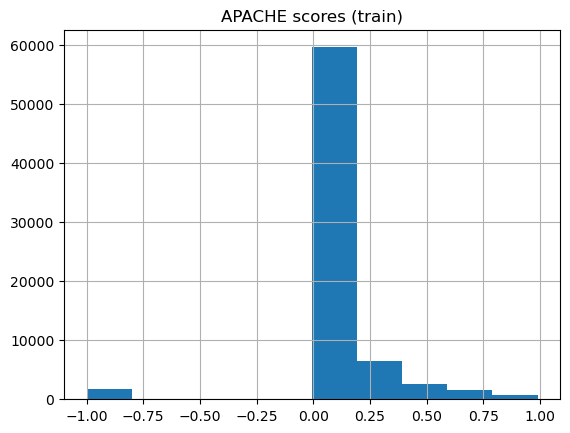

In [53]:
# histogram
y_apache_train.hist()
plt.title("APACHE scores (train)")
plt.show()

# Improved XGBoost model

In [55]:
# Define XGBoost parameters
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'eta': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'n_estimators': 100
}

# Convert dataset to DMatrix format 
dtrain = xgb.DMatrix(X_train, label=y_train)

# Perform cross-validation
cv_results = cross_val_score(xgb.XGBClassifier(**params), X_train, y_train, cv=5, scoring='neg_log_loss')

# Convert negative log loss to positive
cv_results = -cv_results

# Print cross-validation results
print("Cross-validation Log Loss:", cv_results)
print("Mean Log Loss:", np.mean(cv_results))

# Train the final model with the entire training set
xgb_model = xgb.train(params, dtrain)


Cross-validation Log Loss: [0.20177034 0.19749021 0.19799159 0.19145978 0.19941115]
Mean Log Loss: 0.1976246128684208


D:\Users\david_p3b8pan\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:04:04] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


In [56]:
# Convert test set to DMatrix format
dtest = xgb.DMatrix(X_test)

# Make predictions on the test set
y_pred_proba = xgb_model.predict(dtest)
y_pred_binary = (y_pred_proba >= 0.5).astype(int)  # Convert probabilities to binary predictions

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)
roc_auc = roc_auc_score(y_test, y_pred_proba)
conf_matrix = confusion_matrix(y_test, y_pred_binary)

# Print evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC Score:", roc_auc)
print("Confusion Matrix:\n", conf_matrix)


Accuracy: 0.9161887957653286
Precision: 0.7710843373493976
Recall: 0.07950310559006211
F1 Score: 0.14414414414414414
ROC AUC Score: 0.859437378179913
Confusion Matrix:
 [[8244   19]
 [ 741   64]]


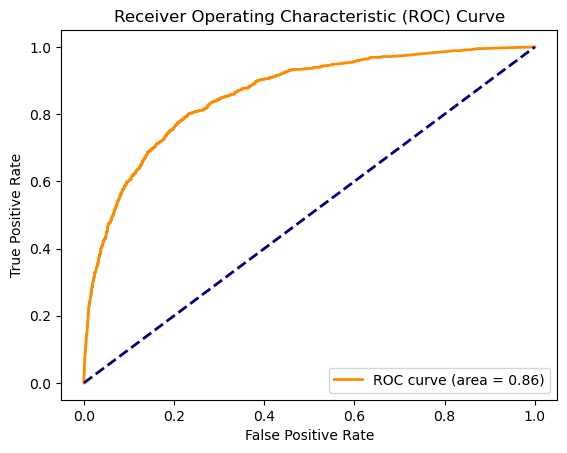

In [57]:
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig("ROC_curve.png")
plt.show()


In [58]:
# importance = xgb_model.feature_importances_
# plt.bar(range(len(importance)), importance)
# plt.show()

# print("Feature Importance:", importance)


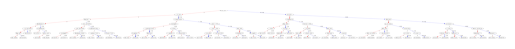

In [59]:
xgb.plot_tree(xgb_model)
plt.savefig("Model_Tree.png")
plt.show()


In [60]:
# Evaluate the apache model
y_apache_binary = (y_apache_test >= 0.5).astype(int)  # Convert probabilities to binary predictions


accuracy2 = accuracy_score(y_test, y_apache_binary)
precision2 = precision_score(y_test, y_apache_binary)
recall2 = recall_score(y_test, y_apache_binary)
f12 = f1_score(y_test, y_apache_binary)
roc_auc2 = roc_auc_score(y_test, y_apache_test)
conf_matrix2 = confusion_matrix(y_test, y_apache_binary)

# Print evaluation metrics
print("Accuracy:", accuracy2)
print("Precision:", precision2)
print("Recall:", recall2)
print("F1 Score:", f12)
print("ROC AUC Score:", roc_auc2)
print("Confusion Matrix:\n", conf_matrix2)


Accuracy: 0.913542126157918
Precision: 0.5230769230769231
Recall: 0.2956521739130435
F1 Score: 0.3777777777777778
ROC AUC Score: 0.828012399809673
Confusion Matrix:
 [[8046  217]
 [ 567  238]]


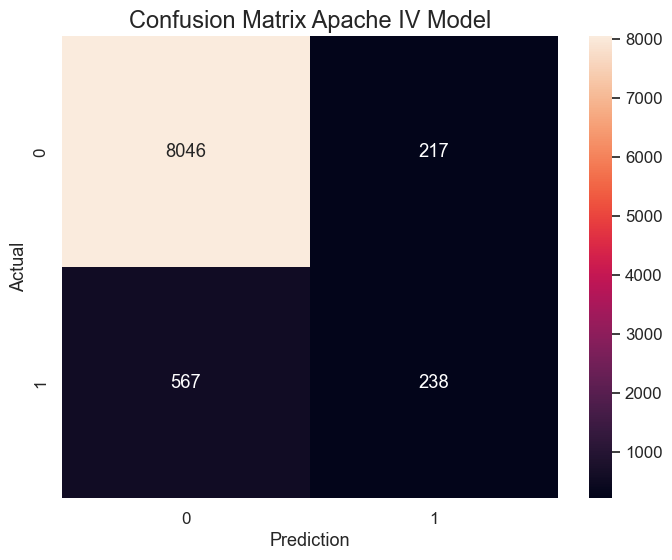

In [61]:
cm = confusion_matrix(y_test,y_apache_binary)

plt.figure(figsize=(8,6), dpi=100)
sns.set(font_scale = 1.1)
ax = sns.heatmap(conf_matrix2, 
            annot=True,
            fmt='d', )
ax.set_ylabel('Actual',fontsize=13)
ax.set_xlabel('Prediction',fontsize=13)
ax.set_title('Confusion Matrix Apache IV Model',fontsize=17)
plt.savefig("cm_Apache.png")
plt.show()


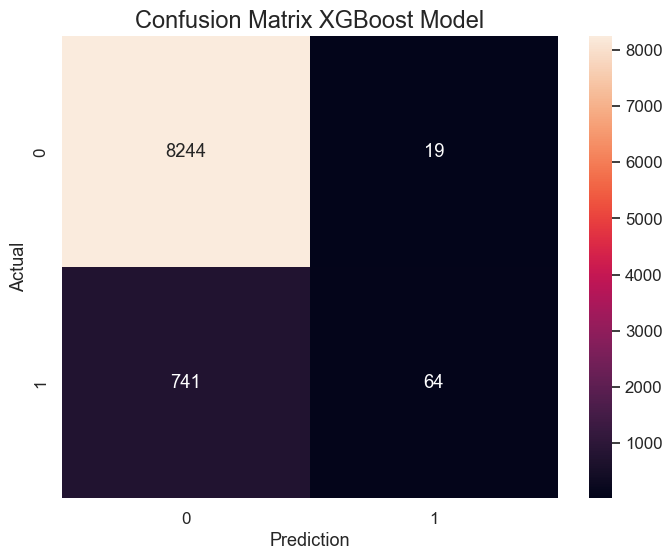

In [62]:
cm = confusion_matrix(y_test,y_pred_binary)

plt.figure(figsize=(8,6), dpi=100)
sns.set(font_scale = 1.1)
ax = sns.heatmap(conf_matrix, 
            annot=True,
            fmt='d', )
ax.set_ylabel('Actual',fontsize=13)
ax.set_xlabel('Prediction',fontsize=13)
ax.set_title('Confusion Matrix XGBoost Model',fontsize=17)
plt.savefig("cm_Model.png")
plt.show()


# LIME


In [118]:
# import libraries
import time
import pandas as pd
import numpy as np
import matplotlib
import sklearn
import fairlearn
import shap
import lime

# import specific functionality
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from fairlearn.metrics import true_positive_rate, true_negative_rate
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import PartialDependenceDisplay
from shap import Explainer
from lime.lime_tabular import LimeTabularExplainer

# this tutorial has been tested with the following versions
print("pandas        Tested version: 2.0.3   Your version: %s" % pd.__version__)
print("numpy         Tested version: 1.21.5  Your version: %s" % np.__version__)
print("matplotlib    Tested version: 3.5.3   Your version: %s" % matplotlib.__version__)
print("scikit-learn  Tested version: 1.3.2   Your version: %s" % sklearn.__version__)
print("fairlearn     Tested version: 0.10.0  Your version: %s" % fairlearn.__version__)
print("shap          Tested version: 0.44.1  Your version: %s" % shap.__version__)
print("lime          Tested version: 0.2.0.1 lime has not set a __version__ attribute, check your local installation")


ModuleNotFoundError: No module named 'fairlearn'